In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
from scipy import interpolate, integrate
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib as mpl
rc('font',size=18)

In [155]:
NDIM = 3

In [651]:
rin = 0
rout = 5
NG = 2
#rout = 200
N1D = 200
grid1d = np.linspace(rin, rout, N1D)
dr1d = grid1d[1] - grid1d[0]

In [997]:
def pseudo2(r, dr):
    return np.maximum(dr*dr*np.ones_like(r), r**2)

def make_X_global(bounds, nx):
    xf_global = []
    xc_global = []
    dx = []
    for i in range(NDIM):
        # faces without ghosts
        xf = np.linspace(bounds[i][0],bounds[i][1],nx[i]+1)
        dx.append(xf[1] - xf[0])
        # incorporate ghost zones
        xf = np.linspace(bounds[i][0] - NG*dx[-1], 
                         bounds[i][1] + NG*dx[-1], 
                         nx[i] + 1 + 2*NG)
        xc = 0.5*(xf[1:] + xf[:-1])
        xf_global.append(xf)
        xc_global.append(xc)
    Xf_global = np.meshgrid(*xf_global, indexing='ij')
    Xc_global = np.meshgrid(*xc_global, indexing='ij')
    
    return Xf_global, Xc_global, dx

def make_X_blocks(Xf_global, Xc_global, nx, nb):
    nx_b = [(n//d) for n,d in zip(nx,nb)]
    Xf_blks = np.empty((nb[0],nb[1],nb[2],NDIM,nx_b[0]+1+2*NG,nx_b[1]+1+2*NG,nx_b[2]+1+2*NG))
    Xc_blks = np.empty((nb[0],nb[1],nb[2],NDIM,nx_b[0]+2*NG,nx_b[1]+2*NG,nx_b[2]+2*NG))
    for ib in range(nb[0]):
        for jb in range(nb[1]):
            for kb in range(nb[2]):
                for d in range(NDIM):
                    Xf_blks[ib,jb,kb,d] = Xf_global[d][nx_b[0]*ib:nx_b[0]*(ib+1)+2*NG+1,
                                                       nx_b[1]*jb:nx_b[1]*(jb+1)+2*NG+1,
                                                       nx_b[2]*kb:nx_b[2]*(kb+1)+2*NG+1]
                    Xc_blks[ib,jb,kb,d] = Xc_global[d][nx_b[0]*ib:nx_b[0]*(ib+1)+2*NG,
                                                       nx_b[1]*jb:nx_b[1]*(jb+1)+2*NG,
                                                       nx_b[2]*kb:nx_b[2]*(kb+1)+2*NG]
    return Xf_blks, Xc_blks, nx_b

def refine_block(Xf, Xc):
    nb = (2, 2, 2)
    nx = (nb[0]*Xc.shape[1] - 2*NG, 
          nb[1]*Xc.shape[2] - 2*NG, 
          nb[2]*Xc.shape[3] - 2*NG)
    nx_b = Xc.shape[1:]
    bounds = [[Xf[0,NG,0,0], Xf[0,-1-NG,0,0]],
              [Xf[1,0,NG,0], Xf[1,0,-1-NG,0]],
              [Xf[2,0,0,NG], Xf[2,0,0,-1-NG]]]
    Xf_global, Xc_global, nx = make_X_global(bounds,nx)
    Xf_new = []
    Xc_new = []
    for ib in range(nb[0]):
        for jb in range(nb[1]):
            for kb in range(nb[2]):
                Xf_loc = []
                Xc_loc = []
                for d in range(NDIM):
                    Xf_loc.append(Xf_global[d][nx_b[0]*ib:nx_b[0]*(ib+1)+1,
                                               nx_b[1]*jb:nx_b[1]*(jb+1)+1,
                                               nx_b[2]*kb:nx_b[2]*(kb+1)+1])
                    Xc_loc.append(Xc_global[d][nx_b[0]*ib:nx_b[0]*(ib+1),
                                               nx_b[1]*jb:nx_b[1]*(jb+1),
                                               nx_b[2]*kb:nx_b[2]*(kb+1)])
                Xf_new.append(np.stack(Xf_loc))
                Xc_new.append(np.stack(Xc_loc))
    return Xf_new, Xc_new

def refine_and_flatten_blocks(Xf_blks, Xc_blks, blocks_to_refine = None):
    Xf_out = []
    Xc_out = []
    for ib in range(Xc_blks.shape[0]):
        for jb in range(Xc_blks.shape[1]):
            for kb in range(Xc_blks.shape[2]):
                if blocks_to_refine is not None and [ib,jb,kb] in blocks_to_refine:
                    Xf_new, Xc_new = refine_block(Xf_blks[ib,jb,kb],Xc_blks[ib,jb,kb])
                    Xf_out += Xf_new
                    Xc_out += Xc_new
                else:
                    Xf_out.append(Xf_blks[ib,jb,kb])
                    Xc_out.append(Xc_blks[ib,jb,kb])
    return np.stack(Xf_out), np.stack(Xc_out)

def get_coords_sph(Xc_blks, cartesian = False):
    if cartesian:
        r_blks = np.sqrt(Xc_blks[:,0,:,:,:]**2 + Xc_blks[:,1,:,:,:]**2 + Xc_blks[:,2,:,:]**2)
        r_blks_cyl = np.sqrt(Xc_blks[:,0,:,:,:]**2 + Xc_blks[:,1,:,:,:]**2)
        th_blks = np.arctan2(Xc_blks[:,2,:,:,:], r_blks_cyl)
        ph_blks = np.arctan2(Xc_blks[:,1,:,:,:], Xc_blks[:,0,:,:,:])
    else:
        r_blks = Xc_blks[:,0,:,:,:]
        th_blks = Xc_blks[:,1,:,:,:]
        ph_blks = Xc_blks[:,2,:,:,:] 
    return r_blks, th_blks, ph_blks

def get_dx_blks(Xf_blks):
    # cell widths defined at faces
    dx1_blks = Xf_blks[:,0,1:,:,:] - Xf_blks[:,0,:-1,:,:]
    dx2_blks = Xf_blks[:,1,:,1:,:] - Xf_blks[:,1,:,:-1,:]
    dx3_blks = Xf_blks[:,2,:,:,1:] - Xf_blks[:,2,:,:,:-1]
    # cell widths defined at cell centers
    dx1_blks  = 0.25*(dx1_blks[:,:,1:,1:] + dx1_blks[:,:,:-1,:-1] 
                     + dx1_blks[:,:,1:,:-1] + dx1_blks[:,:,:-1,1:])
    dx2_blks = 0.25*(dx2_blks[:,1:,:,1:] + dx2_blks[:,:-1,:,:-1]
                     + dx2_blks[:,1:,:,:-1] + dx2_blks[:,:-1,:,1:])
    dx3_blks = 0.25*(dx3_blks[:,1:,1:,:] + dx3_blks[:,:-1,:-1,:]
                     + dx3_blks[:,1:,:-1,:] + dx3_blks[:,:-1,1:,:])
    return dx1_blks, dx2_blks, dx3_blks

def get_dx_sph(Xf_blks, r_blks, th_blks, ph_blks, cartesian = False):
    dx1_blks, dx2_blks, dx3_blks = get_dx_blks(Xf_blks)
    if cartesian:
        r = r_blks
        th = th_blks
        ph = ph_blks
        dx = dx1_blks
        dy = dx2_blks
        dz = dx3_blks
        dr_blks  = dz*np.cos(th) + np.sin(th)*(dx*np.cos(ph) + dy*np.sin(ph))
        dth_blks = r*(-dz*np.sin(th) + np.cos(th)*(dx*np.cos(ph) + dy*np.sin(ph)))
        dph_blks = r*np.sin(th)*(dy*np.cos(ph) - dx*np.sin(ph))
        return dr_blks, dth_blks, dph_blks
    else:
        return dx1_blks, dx2_blks, dx3_blks

def spherically_average(y_monopole, y_blks, 
                        Xf_blks, Xc_blks, grid1d, nx_b,
                        cartesian = False,
                        cell_fac = 3):
    dr1d = grid1d[1] - grid1d[0]
    
    r_blks, th_blks, ph_blks = get_coords_sph(Xc_blks, cartesian)
    dr_blks, dth_blks, dph_blks = get_dx_sph(Xf_blks, r_blks, th_blks, ph_blks, cartesian)
    r_faces, th_faces, ph_faces = get_coords_sph(Xf_blks, cartesian)
    
    # r^2 sin(th) dth dph y
    drmin = dr_blks.min()
    y_integrand_blks = r_blks*r_blks*np.sin(th_blks)*dth_blks*dph_blks*y_blks
    y_integrand_blks_alt = ((3*drmin)**2)*np.sin(th_blks)*dth_blks*dph_blks*y_blks
    div_fac = 4*np.pi*pseudo2(grid1d,3*drmin)
     
    y_avgd = np.zeros_like(y_monopole)
    numblocks = Xc_blks.shape[0]
    for ib in range(numblocks):
        face_inner = r_faces[ib,NG:-NG,NG:-NG,NG:-NG].min()
        face_outer = r_faces[ib,NG:-NG,NG:-NG,NG:-NG].max()
        for i in range(nx_b[0]+2*NG):
            for j in range(NG,nx_b[1]+NG):
                for k in range(NG,nx_b[2]+NG):
                    r0 = r_blks[ib,i,j,k]
                    y0_base = y_integrand_blks[ib,i,j,k]
                    y0_alt = y_integrand_blks_alt[ib,i,j,k]                       
                    dr = dr_blks[ib,i,j,k]
                    bl = r0 - dr
                    br = r0 + dr
                    il = np.where(np.logical_and(grid1d >= bl,grid1d >= face_inner))[0]
                    #il = np.where(grid1d >= bl)[0]
                    if len(il) > 0:
                        il = il[0]
                    else:
                        il = 0
                    ir = np.where(np.logical_or(grid1d > br, grid1d > face_outer))[0]
                    #ir = np.where(grid1d > br)[0]
                    if len(ir) > 0:
                        ir = ir[0]
                    else:
                        ir = len(grid1d)
                    for imono in range(il, ir):
                        r = grid1d[imono]
                        y0 = (y0_alt if np.abs(r) <= 3*dr else y0_base)
                        y_avgd[imono] += y0*max(0,(1 - np.abs(r - r0)/dr))
                        #y_avgd[imono] += y0 if r0 <= dr/2 and r <= dr/2 else y0*max(0,(1 - np.abs(r - r0)/dr))
                            
    y_avgd /= div_fac
    y_avgd[0] = y_avgd[1]
    return y_avgd

# Container class
class SphericalAverage:
    def __init__(self, rout, n1d, nx, nb,
                 blocks_to_refine = None,
                 cartesian = False,
                 sigma = 0.5, cell_fac = 3):
        rin = 0
        self.rin = rin
        self.rout = rout
        self.n1d = n1d
        self.nx = nx
        self.nb = nb
        self.blocks_to_refine = blocks_to_refine
        self.cartesian = cartesian
        self.sigma = sigma
        self.cell_fac = cell_fac
        
        # generate grids
        print("Generating grids")
        self.grid1d = np.linspace(rin, rout, n1d)
        if cartesian:
            self.bounds = [-(rout, rout), (-rout, rout), (-rout, rout)]
        else:
            self.bounds = [(rin,rout), (0, np.pi), (0, 2*np.pi)]
        self.Xf_global, self.Xc_global, self.dx = make_X_global(bounds, nx)
        Xf_blks, Xc_blks, self.nx_b = make_X_blocks(self.Xf_global, self.Xc_global, nx, nb)
        self.Xf_blks, self.Xc_blks = refine_and_flatten_blocks(Xf_blks, Xc_blks, blocks_to_refine)
        
        # generate function to interpolate
        print("Generating functions")
        self.y_monopole = np.exp(-(self.grid1d/(2*sigma))**2)
        
        # put it on the 3d mesh
        self.r_blks, _, _ = get_coords_sph(self.Xc_blks, cartesian)
        self.y_blks = np.exp(-(self.r_blks/(2*sigma))**2)
        
        # average it back on to the 1d mesh
        print("Interpolating")
        self.y_avgd = spherically_average(self.y_monopole,self.y_blks, 
                                          self.Xf_blks, self.Xc_blks, 
                                          self.grid1d, self.nx_b,
                                          cartesian, cell_fac)
        print("Done")

In [998]:
savg = SphericalAverage(5, 200, [128, 16, 16], [2, 2, 2],
                        #[[0,0,0],[0,1,0],[0,0,1],[0,1,1]],
                        sigma=1)

Generating grids
Generating functions
Interpolating
Done


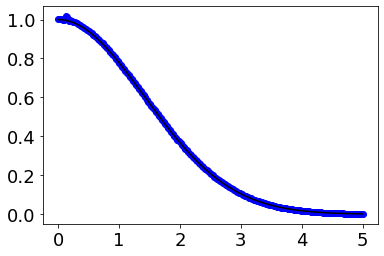

In [999]:
plt.plot(savg.grid1d,savg.y_avgd,'bo')
plt.plot(savg.grid1d,savg.y_monopole,'k-')
#plt.xlim(2.25,2.75)
#plt.ylim(0.,0.2)

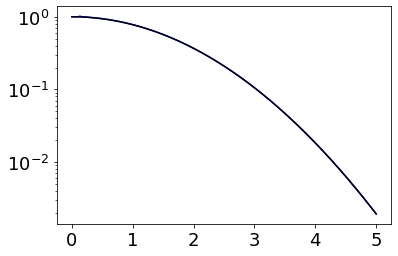

In [1000]:
plt.semilogy(savg.grid1d,savg.y_avgd,'b-')
plt.plot(savg.grid1d,savg.y_monopole,'k-')
#plt.xlim(2.25,2.75)
#plt.ylim(0.,0.2)

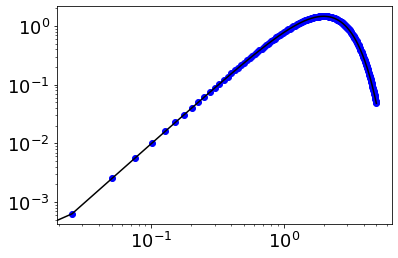

In [983]:
plt.loglog(savg.grid1d,savg.grid1d*savg.grid1d*savg.y_avgd,'bo')
plt.plot(savg.grid1d,savg.grid1d*savg.grid1d*savg.y_monopole,'k-')

2.382659e-02
5.799389e-03


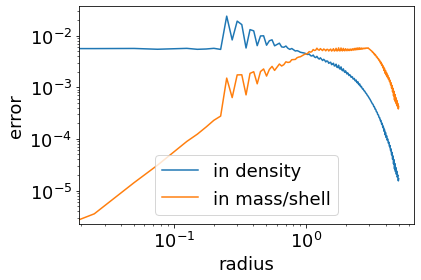

In [979]:
delta_y = savg.y_avgd - savg.y_monopole
err = np.minimum(np.abs(delta_y),np.abs(delta_y)/(savg.y_monopole + 1e-12))
print('%e' % err.max())
plt.loglog(savg.grid1d, err,label='in density')

delta_y = savg.grid1d*savg.grid1d*(savg.y_avgd - savg.y_monopole)
err = np.minimum(np.abs(delta_y),np.abs(delta_y)/(savg.grid1d*savg.grid1d*savg.y_monopole + 1e-12))
print('%e' % err.max())
plt.loglog(savg.grid1d, err,label='in mass/shell')

plt.xlabel('radius')
plt.ylabel('error')
plt.legend()

In [814]:
mass_avgd = integrate.trapz(4*np.pi*savg.grid1d**2*savg.y_avgd,x=savg.grid1d)
mass_orig = integrate.trapz(4*np.pi*grid1d**2*y_monopole,x=grid1d)
print("%e %e %e" % (mass_avgd, mass_orig, (mass_avgd - mass_orig)/mass_orig))

4.317346e+01 5.568328e+00 6.753398e+00


In [815]:
%pwd

'/mnt/hgfs/host/programming/phoebus/scripts/jupyter'

Generating grids
Generating functions
Interpolating
Done
-0.0923663443094607
Generating grids
Generating functions
Interpolating
Done
-0.02514166692290371
Generating grids
Generating functions
Interpolating
Done
-0.007284408144078911


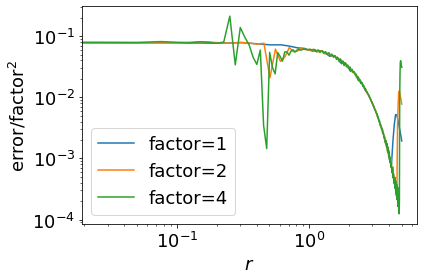

In [840]:
n1d_base = 50
nblk_base = 16
max_errs = []
mass_errs = []
resfacs = [1,2,4]
for resfac in resfacs:
    savg = SphericalAverage(5, n1d_base*resfac, 
                            [nblk_base*resfac,nblk_base*resfac,nblk_base*resfac], 
                            [2, 2, 2], sigma = 1)
                            #[[0,0,0],[0,1,0],[0,0,1],[0,1,1]])
    delta_y = savg.y_avgd - savg.y_monopole
    err = np.minimum(np.abs(delta_y),np.abs(delta_y)/(savg.y_monopole + 1e-12))
    max_errs.append(err.max())
    mass_avgd = integrate.trapz(4*np.pi*savg.grid1d**2*savg.y_avgd,x=savg.grid1d)
    mass_orig = integrate.trapz(4*np.pi*savg.grid1d**2*savg.y_monopole,x=savg.grid1d)
    mass_errs.append((mass_avgd - mass_orig)/mass_orig)
    print(mass_errs[-1])
    plt.loglog(savg.grid1d, (resfac**2)*err,label=f'factor={resfac}')
    #plt.plot(savg.grid1d, err,label=f'factor={resfac}')
plt.legend()
plt.xlabel(r'$r$')
plt.ylabel(r'error$/$factor$^2$')
#plt.ylim(1e-6,1e-1)

plt.savefig('interpolation_error_gaussian_spherical_3d_multiblock.png',
            bbox_inches='tight',
            dpi=300)

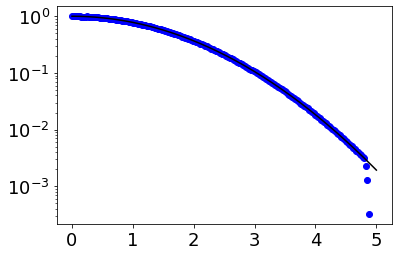

In [841]:
plt.semilogy(savg.grid1d,savg.y_avgd,'bo')
plt.plot(savg.grid1d,savg.y_monopole,'k-')

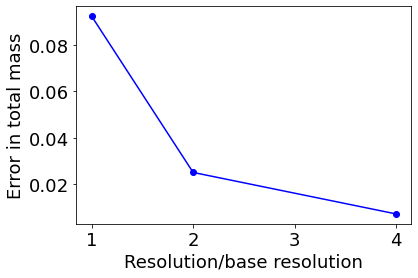

In [843]:
plt.plot(resfacs,np.abs(mass_errs),'bo-')
plt.xlabel('Resolution/base resolution')
plt.ylabel('Error in total mass')
plt.savefig('interpolation_mass_error_amr_spherical_3d_multiblock.png',bbox_inches='tight',dpi=300)